<a href="https://colab.research.google.com/github/MySureStart/spring_2023_vail-AntoniosMalak/blob/main/Day_13/Computer_Vision_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

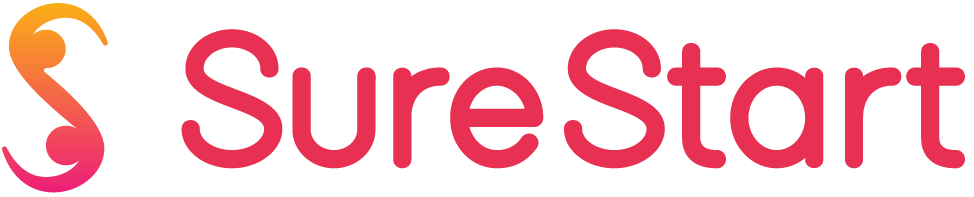

#Day 13 Objectives:
* Introduction to Computer Vision (CV) to understand how machines “see” the visual world. 
* Learn how machines can “read” your emotions by looking at your face.

#Computer Vision
Computer vision is a field of artificial intelligence (AI) that enables computers and systems to derive meaningful information from digital images, videos and other visual inputs — and take actions or make recommendations based on that information. If AI enables computers to think, computer vision enables them to see, observe and understand.

Computer vision works much the same as human vision, except humans have a head start. Human sight has the advantage of lifetimes of context to train how to tell objects apart, how far away they are, whether they are moving and whether there is something wrong in an image.

Computer vision trains machines to perform these functions, but it has to do it in much less time with cameras, data and algorithms rather than retinas, optic nerves and a visual cortex. Because a system trained to inspect products or watch a production asset can analyze thousands of products or processes a minute, noticing imperceptible defects or issues, it can quickly surpass human capabilities.


In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd

<ipython-input-1-4617c670b37f>:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Talking about GANs in Computer Vision
GANs are a form of neural network in which two sub-networks (the encoder and decoder) are trained on opposing loss functions: an encoder that is trained to produce data which is indiscernable from the true data, and a decoder that is trained to discern between the data and generated data.

### Load fashion-MNIST dataset

In [2]:
TRAIN_BUF=60000
BATCH_SIZE=512
TEST_BUF=10000
DIMS = (28,28,1)
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

In [3]:
# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

# split dataset
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype(
    "float32"
) / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)

4422102/4422102 [==============================] - 0s 0us/step


## Question 1
We have used both numpy array/pandas dataframe and tensorflow datasets. What is the difference in using either to train a model?

### Answer 1


  The main difference between using numpy array/pandas dataframe and TensorFlow datasets to train a model is that TensorFlow datasets provide a more optimized and efficient way to handle large amounts of data. Numpy arrays and Pandas dataframes are suitable for smaller datasets, while TensorFlow datasets are designed for large datasets that require efficient streaming and processing. Additionally, TensorFlow datasets have built-in features for shuffling, batching, and prefetching data, which can improve training performance.


# Define the network architecture

In supervised learning, we may be interested in developing a model to predict a class label given an example of input variables.

This predictive modeling task is called classification.

Classification is also traditionally referred to as discriminative modeling.

This is because a model must discriminate examples of input variables across classes; it must choose or make a decision as to what class a given example belongs. Alternately, unsupervised models that summarize the distribution of input variables may be able to be used to create or generate new examples in the input distribution.

The GAN model architecture involves two sub-models: a generator model for generating new examples and a discriminator model for classifying whether generated examples are real, from the domain, or fake, generated by the generator model.

* **Generator**: Model that is used to generate new plausible examples from the problem domain.
* **Discriminator**: Model that is used to classify examples as real (from the domain) or fake (generated).





## Question 2
Implement a **Discriminator**.

The discriminator model takes an example from the domain as input (real or generated) and predicts a binary class label of real or fake (generated).

The real example comes from the training dataset. The generated examples are output by the generator model.

The discriminator is a well understood classification model which we have already worked on through CNNs.

After the training process, the discriminator model is discarded as we are interested in the generator.

Sometimes, the generator can be repurposed as it has learned to effectively extract features from examples in the problem domain. Some or all of the feature extraction layers can be used in transfer learning applications using the same or similar input data.

### Answer 2

Create the discriminator

It maps a 64x64 image to a binary classification score.


In [4]:
# Enter answer for question 2 here
discriminator = keras.Sequential(
    [
        tf.keras.Input(shape=DIMS),
        tf.keras.layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1088      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4, 128)         0         
                                                                 
 flatten (Flatten)           (None, 2048)            

## Question 3
Implement a **generator**.

The generator model takes a fixed-length random vector as input and generates a sample in the domain.

The vector is drawn from randomly from a Gaussian distribution, and the vector is used to seed the generative process. After training, points in this multidimensional vector space will correspond to points in the problem domain, forming a compressed representation of the data distribution.

This vector space is referred to as a latent space, or a vector space comprised of latent variables. Latent variables, or hidden variables, are those variables that are important for a domain but are not directly observable.

We often refer to latent variables, or a latent space, as a projection or compression of a data distribution. That is, a latent space provides a compression or high-level concepts of the observed raw data such as the input data distribution. In the case of GANs, the generator model applies meaning to points in a chosen latent space, such that new points drawn from the latent space can be provided to the generator model as input and used to generate new and different output examples.



### Answer 3
Create the generator

It mirrors the discriminator, replacing Conv2D layers with Conv2DTranspose layers.

In [6]:
# Enter answer for question 3 here
latent_dim = 128

generator = keras.Sequential(
    [
        tf.keras.Input(shape=(latent_dim,)),
        tf.keras.layers.Dense(7 * 7 * 128),
        tf.keras.layers.Reshape((7, 7, 128)),
        tf.keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Conv2DTranspose(1, kernel_size=4, strides=1, padding="same", activation="sigmoid"),
        tf.keras.layers.Reshape((28, 28, 1)),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              809088    
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 14, 14, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 28, 28, 64)       131136    
 ranspose)                                                       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 28, 28, 64)        0 

#Generative vs. Discriminative Algorithms
To understand GANs, you should know how generative algorithms work, and for that, contrasting them with discriminative algorithms is instructive. Discriminative algorithms try to classify input data; that is, given the features of an instance of data, they predict a label or category to which that data belongs.

For example, given all the words in an email (the data instance), a discriminative algorithm could predict whether the message is spam or not_spam. spam is one of the labels, and the bag of words gathered from the email are the features that constitute the input data. When this problem is expressed mathematically, the label is called y and the features are called x. The formulation p(y|x) is used to mean “the probability of y given x”, which in this case would translate to “the probability that an email is spam given the words it contains.”

So discriminative algorithms map features to labels. They are concerned solely with that correlation. One way to think about generative algorithms is that they do the opposite. Instead of predicting a label given certain features, they attempt to predict features given a certain label.

The question a generative algorithm tries to answer is: Assuming this email is spam, how likely are these features? While discriminative models care about the relation between y and x, generative models care about “how you get x.” They allow you to capture p(x|y), the probability of x given y, or the probability of features given a label or category. (That said, generative algorithms can also be used as classifiers. It just so happens that they can do more than categorize input data.)

Another way to think about it is to distinguish discriminative from generative like this:

* Discriminative models learn the boundary between classes
* Generative models model the distribution of individual classes

## Question 4

Do you see any similartiy or dissimilarity between Autoencoders (Encoder - Decoder) and GANs (Discriminator - Generator)? Describe.  

### Answer 4

Yes, there are similarities and differences between autoencoders and GANs.

Similarities:

- Both autoencoders and GANs are deep learning architectures used for unsupervised learning.
- They learn features from the input data in an unsupervised manner, without requiring explicit labels.
- Both architectures have a bottleneck layer that learns a compressed representation of the input data.
- Both architectures can be used for tasks such as image generation, feature extraction, and anomaly detection.

Differences:

- Autoencoders use an encoder-decoder architecture while GANs use a discriminator-generator architecture.
- The goal of autoencoders is to reconstruct the input data, while GANs aim to generate new data that is similar to the training data.
- Autoencoders are trained using a reconstruction loss, while GANs are trained using an adversarial loss.
- Autoencoders can be trained using a single network, while GANs require the training of two separate networks.
- Autoencoders do not require a training dataset of both real and fake data, while GANs require both.
- Autoencoders are less sensitive to the quality of the input data, while GANs require high-quality data to produce good results.
- Autoencoders are more stable and easier to train than GANs, which can be prone to mode collapse and other issues.

## Define the network as tf.keras.model object

Generative modeling is an unsupervised learning problem, as we discussed in the previous section, although a clever property of the GAN architecture is that the training of the generative model is framed as a supervised learning problem.

Let’s say we’re trying to do something more banal than mimic the Mona Lisa. We’re going to generate hand-written numerals like those found in the MNIST dataset, which is taken from the real world. The goal of the discriminator, when shown an instance from the true MNIST dataset, is to recognize those that are authentic.

Meanwhile, the generator is creating new, synthetic images that it passes to the discriminator. It does so in the hopes that they, too, will be deemed authentic, even though they are fake. The goal of the generator is to generate passable hand-written digits: to lie without being caught. The goal of the discriminator is to identify images coming from the generator as fake.

Here are the steps a GAN takes:

* The generator takes in random numbers and returns an image.
* This generated image is fed into the discriminator alongside a stream of images taken from the actual, ground-truth dataset.
* The discriminator takes in both real and fake images and returns probabilities, a number between 0 and 1, with 1 representing a prediction of authenticity and 0 representing fake.

So you have a double feedback loop:

* The discriminator is in a feedback loop with the ground truth of the images, which we know.
* The generator is in a feedback loop with the discriminator.

Here the GAN model we use incorporate two different sub-models which require us to calculate the loss for it in a different way explicitly. The  tf.keras.models.Sequential.fit() does not support this unless we structure that as tensorflow structures its loss functions. 


In [7]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

# Train the model

Create a callback that periodically saves generated images

Callbacks can be passed to keras methods such as fit, evaluate, and predict in order to hook into the various stages of the model training and inference lifecycle.

To create a custom callback, subclass keras.callbacks.Callback and override the method associated with the stage of interest. See https://www.tensorflow.org/guide/keras/custom_callback for more information.

In [8]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))

In [9]:
epochs = 1  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

gan.fit(
    train_dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)


118/118 [==============================] - 26s 120ms/step - d_loss: 0.3984 - g_loss: 1.3487


While we can just train the model, we also want to see what the model is learning, run the below code to plot the generated images by the GAN.

In [10]:
# exampled data for plotting results
def plot_reconstruction(model, nex=8, zm=2):
    samples = model.generator(tf.random.normal(shape=(BATCH_SIZE, latent_dim)))
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].matshow(
                    samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
                )
        axs[axi].axis('off')
    plt.show()

118/118 [==============================] - 14s 118ms/step - d_loss: 0.4982 - g_loss: 1.6849


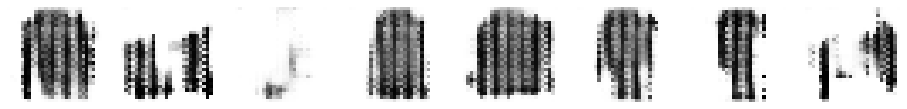

118/118 [==============================] - 14s 118ms/step - d_loss: 0.5070 - g_loss: 1.4206


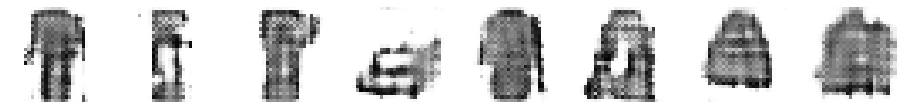

118/118 [==============================] - 14s 120ms/step - d_loss: 0.5314 - g_loss: 1.3704


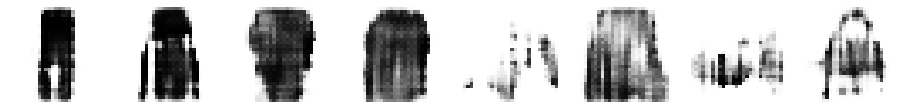

118/118 [==============================] - 14s 118ms/step - d_loss: 0.5332 - g_loss: 1.3169


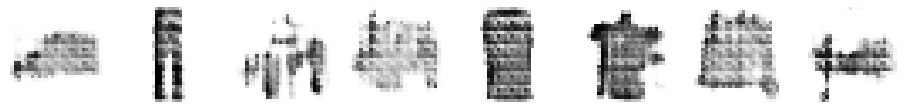

118/118 [==============================] - 14s 121ms/step - d_loss: 0.5295 - g_loss: 1.2908


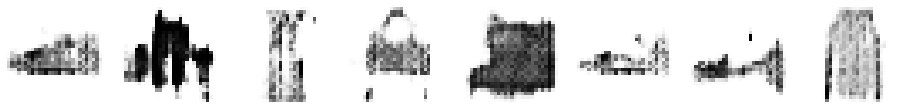

118/118 [==============================] - 14s 119ms/step - d_loss: 0.5019 - g_loss: 1.4058


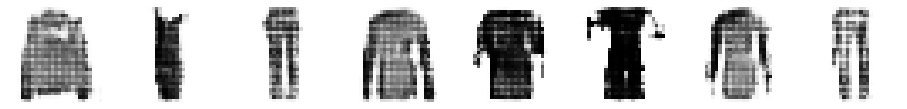

118/118 [==============================] - 14s 119ms/step - d_loss: 0.5072 - g_loss: 1.3205


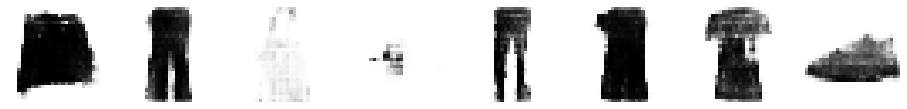

118/118 [==============================] - 14s 119ms/step - d_loss: 0.5471 - g_loss: 1.2685


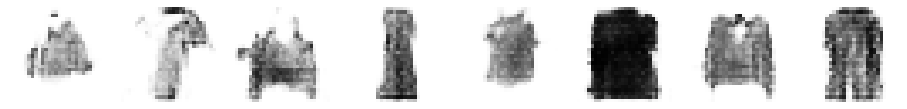

118/118 [==============================] - 14s 121ms/step - d_loss: 0.5443 - g_loss: 1.3077


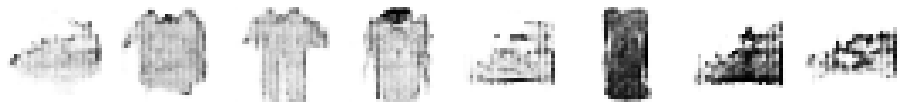

118/118 [==============================] - 14s 121ms/step - d_loss: 0.5438 - g_loss: 1.2592


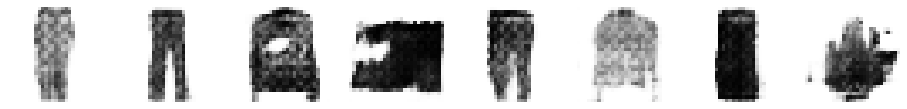

118/118 [==============================] - 14s 119ms/step - d_loss: 0.4942 - g_loss: 1.3485


In [13]:
n_epochs = 100
for epoch in range(n_epochs):
    # train
    gan.fit(
    train_dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)
    if epoch%10 ==0:
      plot_reconstruction(gan)

# **Upload this Day 13 Colab Notebook to your Github repository under "Day 13" folder. Also add your *Reflection* on today's learning in README.md**